# Task: Fine-tuning a language model to generate child-appropriate stories

Some notes:
* We will use (a simplified version of) DPO (Direct Preference Optimization), which is a simple RLHF fine-tuning method
* We will fine-tune a GPT2, is a small model with 124M  parameters

<a target="_blank" href="https://colab.research.google.com/github/MENA-ML/tutorials2025-solutions/blob/main/rlhf/dpo_Solution.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
#@title Imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, GPT2LMHeadModel, BertModel, BertTokenizer


from sklearn.cluster import KMeans
import numpy as np

import pickle
from google.colab import files

import pandas as pd

import matplotlib.pyplot as plt

from random import shuffle

In [ ]:
#@title Parameters

max_story_length = 100
temp = 0.9
emb_model_name='bert-base-uncased'
model_name = 'gpt2'

FT_PATH = 'drive/MyDrive/model/gpt2/'

## Training modules

In [ ]:
#@title Data modules

# Here we assume we have pairs {prompt, chosen_response, rejected_response}
class PreferenceDataset(Dataset):
    """
    A dataset of pairs (prompt, chosen_response, rejected_response).
    """
    def __init__(self, tokenizer, data, max_length=128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        prompt = sample['prompt']
        chosen = sample['chosen']
        rejected = sample['rejected']

        prompt_ids = self.tokenizer.encode(prompt, add_special_tokens=False)
        chosen_ids = self.tokenizer.encode(chosen, add_special_tokens=False)
        rejected_ids = self.tokenizer.encode(rejected, add_special_tokens=False)

        return {
            'prompt_ids': prompt_ids,
            'chosen_ids': chosen_ids,
            'rejected_ids': rejected_ids
        }

def collate_fn(batch, tokenizer, max_length=128):
    """
    Collate function that pads concatenated prompt+response sequences
    for chosen and rejected. Returns:
      - input_ids_chosen, attention_mask_chosen
      - input_ids_rejected, attention_mask_rejected
    """
    chosen_batch = []
    rejected_batch = []

    for sample in batch:
        # Concatenate prompt and response
        chosen_ids = sample['prompt_ids'] + sample['chosen_ids']
        rejected_ids = sample['prompt_ids'] + sample['rejected_ids']

        # Truncate to max_length if needed
        chosen_ids = chosen_ids[:max_length]
        rejected_ids = rejected_ids[:max_length]

        chosen_batch.append(chosen_ids)
        rejected_batch.append(rejected_ids)

    chosen_tensor = tokenizer.pad(
        {'input_ids': chosen_batch},
        padding=True,
        return_tensors='pt'
    )
    rejected_tensor = tokenizer.pad(
        {'input_ids': rejected_batch},
        padding=True,
        return_tensors='pt'
    )

    return (
        chosen_tensor['input_ids'],
        chosen_tensor['attention_mask'],
        rejected_tensor['input_ids'],
        rejected_tensor['attention_mask'],
    )


In [ ]:
#@title DPO implementation

#    Based on
#    "Direct Preference Optimization: Your Language Model is
#    Secretly a Reward Model" (Rafailov et al. 2024).
def dpo_loss(
    chosen_logps,
    rejected_logps,
    alpha=1.0,
):
    """
    chosen_logps, rejected_logps: shape [batch_size, seq_len]
    alpha: hyperparameter controlling strength of likelihood ratio
    Excerpt formula:
       L = - E[ log( 1 / (1 + exp( - (r_chosen - r_rejected) )) ) ]
    where r_* ~ alpha * log p_\theta(*)
    """
    # Sum log probabilities over the sequence to get total log-likelihood
    chosen_logp_sum = torch.sum(chosen_logps, dim=-1)
    rejected_logp_sum = torch.sum(rejected_logps, dim=-1)

    # r_chosen = alpha * chosen_logp_sum, r_rejected = alpha * rejected_logp_sum
    r_chosen = alpha * chosen_logp_sum
    r_rejected = alpha * rejected_logp_sum

    # DPO loss
    # logistic = 1 / (1 + exp(-(r_chosen - r_rejected)))
    # loss = - log(logistic) = log(1 + exp(-(r_chosen - r_rejected)))
    logits_diff = r_chosen - r_rejected
    loss = torch.log1p(torch.exp(-logits_diff))
    return loss.mean()

def compute_logprobs(logits, input_ids):
    """
    Compute log probabilities of the model for each token in input_ids.
    logits: [batch_size, seq_len, vocab_size]
    input_ids: [batch_size, seq_len]
    returns: log_probs per token, shape [batch_size, seq_len]
    """
    # Shift for next-token prediction: We want P(x_{t+1} | x_{<=t})
    # So logits[:, t, :] corresponds to the probability of the next token after t.
    shift_logits = logits[..., :-1, :].contiguous()  # [batch_size, seq_len-1, vocab_size]
    shift_labels = input_ids[..., 1:].contiguous()   # [batch_size, seq_len-1]

    # Flatten for cross entropy
    flatten_logits = shift_logits.view(-1, shift_logits.size(-1))
    flatten_labels = shift_labels.view(-1)

    log_probs = nn.functional.log_softmax(flatten_logits, dim=-1)
    token_log_probs = log_probs[torch.arange(log_probs.size(0)), flatten_labels]
    token_log_probs = token_log_probs.view(logits.size(0), -1)  # [batch_size, seq_len-1]

    # Pad back to original seq_len if desired
    # For simplicity, we keep it seq_len - 1 here
    return token_log_probs

# Bringing it all together in a training loop
def train_dpo(
    model,
    tokenizer,
    dataset,
    batch_size=2,
    alpha=1.0,
    lr=1e-5,
    num_epochs=2,
    max_length=128,
):
    """
    Training loop of DPO.
    """
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda b: collate_fn(b, tokenizer, max_length=max_length),
    )

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    model.train()

    for epoch in range(num_epochs):
        for step, (chosen_ids, chosen_mask, rejected_ids, rejected_mask) in enumerate(data_loader):
            chosen_ids = chosen_ids.cuda() if torch.cuda.is_available() else chosen_ids
            chosen_mask = chosen_mask.cuda() if torch.cuda.is_available() else chosen_mask
            rejected_ids = rejected_ids.cuda() if torch.cuda.is_available() else rejected_ids
            rejected_mask = rejected_mask.cuda() if torch.cuda.is_available() else rejected_mask

            # Forward pass for chosen
            outputs_chosen = model(input_ids=chosen_ids, attention_mask=chosen_mask)
            # Forward pass for rejected
            outputs_rejected = model(input_ids=rejected_ids, attention_mask=rejected_mask)

            # Compute log probabilities per token
            chosen_logps = compute_logprobs(outputs_chosen.logits, chosen_ids)
            rejected_logps = compute_logprobs(outputs_rejected.logits, rejected_ids)

            # Compute DPO loss
            loss = dpo_loss(chosen_logps, rejected_logps, alpha=alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % 100 == 0:
                print(f'Epoch {epoch}, Step {step}')



## Show initial performance before fine-tuning

In [ ]:
#@title Generate stories using GPT2 model

num_stories = 100

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # GPT2 doesn't have a pad_token, so use eos

model = GPT2LMHeadModel.from_pretrained(model_name)
if torch.cuda.is_available():
    model.cuda()

gpt2_stories = []
for i in range(num_stories):
  inputs = tokenizer('Here is a short story plot: ', return_tensors='pt')
  inputs.to(torch.device('cuda:0'))
  generation_output = model.generate(
      **inputs,
      do_sample=True,
      temperature=temp,
      max_length=max_story_length,
      pad_token_id=tokenizer.eos_token_id
      )
  out = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(generation_output[0]))
  gpt2_stories.append(out)
  #print(out)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
#@title Save gpt2-stories

stories = []
for story in gpt2_stories:
  story = story.split("Here is a short story plot:",1)[1]
  stories.append(story)
with open('gpt2_stories.pkl', 'wb') as file:
  pickle.dump(stories, file)

In [ ]:
#@title Load GPT2-generated stories if we already have them...
# Load appropriate and inappropriate stories (from an external source)

"""
files.upload()

with open('gpt2_stories.pkl', 'rb') as file:
    gpt2_stories = pickle.load(file)

print('\n\n')

print('A sample story generated by GPT2: ')
print(gpt2_stories[10].replace('\xa0', ' '))
"""

In [ ]:
files.upload()
df = pd.read_csv('50_Childrens_Stories.csv')

files.upload()
df2 = pd.read_csv('50_Short_Stories.csv')

children_stories = []
for index, row in df.iterrows():
    children_stories.append(row['Story  '])

adult_stories = []
for index, row in df2.iterrows():
    adult_stories.append(row['Content'])

print('\n\n')

print('Sample children story: ')
print(children_stories[0])

print('\n\n')

print('Sample story with adult content: ')
print(adult_stories[20])

Saving 50_Childrens_Stories.csv to 50_Childrens_Stories.csv


Saving 50_Short_Stories.csv to 50_Short_Stories.csv



Sample children story: 
Ella found a crayon in her backyard. When she drew a flower, it bloomed in real life! She drew a tree, and it grew tall and strong. Excited, she drew a castle, but it was too big for her yard. The crayon whispered, 'Use me wisely.' Ella smiled and drew a playground for all the kids in her neighborhood.  



Sample story with adult content: 
After her husband’s death, Mary found a note in his desk. “If anything happens to me, it wasn’t an accident,” it read. She showed it to the police, but they dismissed it. That night, she heard footsteps in her house.


In [ ]:
#@title Cluster BERT embeddings of stories

def get_embeddings(stories, tokenizer, model):

  all_embeddings = []

  for story in stories:

    input_ids = tokenizer.encode(story[:max_story_length], add_special_tokens=True)
    input_ids = torch.tensor([input_ids])

    with torch.no_grad():
      last_hidden_states = model(input_ids)[0] # Models outputs are now tuples
    last_hidden_states = last_hidden_states.mean(1)

    all_embeddings.append(last_hidden_states)

  X = np.array([t.detach().cpu().numpy() for t in all_embeddings]).squeeze()

  return X


emb_tokenizer = BertTokenizer.from_pretrained(emb_model_name)
emb_model = BertModel.from_pretrained(emb_model_name)

all_stories = children_stories + adult_stories + gpt2_stories
num_children_stories = len(children_stories)
num_adult_stories = len(adult_stories)
num_gpt2_stories = len(gpt2_stories)
num_stories = len(all_stories)

X = get_embeddings(all_stories, emb_tokenizer, emb_model)

X_comp = X[:num_children_stories+num_adult_stories,:]
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(X_comp)
centers = np.array(kmeans.cluster_centers_)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

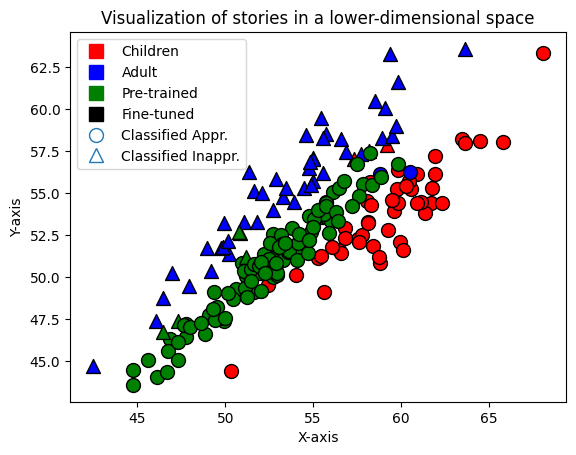

In [ ]:
#@title Visualize GPT2-generated stories (before fine-tuning)

# Create a scatter plot
def myPlot(x, colors, markers):

  for i in range(x.shape[0]):
    plt.scatter(
        x[i,0], x[i,1],
        c=colors[i],
        marker=markers[i],
        edgecolor='k',
        s=100
    )

  legend = [
      plt.Line2D([0], [0], color='red', marker='s', linestyle='',
                 markersize=10, label='Children'),
      plt.Line2D([0], [0], color='blue', marker='s', linestyle='',
                 markersize=10, label='Adult'),
      plt.Line2D([0], [0], color='green', marker='s', linestyle='',
                 markersize=10, label='Pre-trained'),
      plt.Line2D([0], [0], color='black', marker='s', linestyle='',
                 markersize=10, label='Fine-tuned'),
      plt.Line2D([0], [0], marker='o', linestyle='',
                 markersize=10, label='Classified Appr.', fillstyle='none'),
      plt.Line2D([0], [0], marker='^', linestyle='',
                 markersize=10, label='Classified Inappr.', fillstyle='none')
  ]
  plt.legend(handles=legend)

  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.title('Visualization of stories in a lower-dimensional space')
  plt.show()


# find labels for the gpt2-generated stories
X_gpt2 = X[-num_gpt2_stories:,:]
Y = X_gpt2 @ centers.transpose()
gpt2_labels = (Y[:,0] < Y[:,1]).astype(int)
all_labels = np.concatenate([kmeans.labels_, gpt2_labels], axis=0)
#print(all_labels)

colors = [0]*num_stories
for i in range(num_stories):
  if i < num_children_stories:
    colors[i] = 'red'
  elif i < num_children_stories+num_adult_stories:
    colors[i] = 'blue'
  else:
    colors[i] = 'green'

markers = ['o' if label == 0 else '^' for label in all_labels]

x = X @ centers.transpose()

myPlot(x, colors, markers)

## Run DPO

In [ ]:
#@title Create a comparison dataset for RLHF

comparison_data = []
for chosen in children_stories:
  for rejected in adult_stories:
    comparison = {
        'prompt': 'Here is a short story plot: ',
        'chosen': chosen,
        'rejected': rejected
    }
    comparison_data.append(comparison)

shuffle(comparison_data)

In [ ]:
comparison_data[0]

{'prompt': 'Here is a short story plot: ',
 'chosen': "Lila found a bottle on the beach with a note inside. 'Help me find my treasure,' it read. She followed the map and found a chest filled with seashells and a thank-you note from a friendly crab.  ",
 'rejected': 'Mark sat across from his wife, the weight of his secret suffocating him. “I need to tell you something,” he said, his voice trembling. Her eyes narrowed, her fork pausing mid-air. “I wasn’t at work last night.” Her silence was deafening. “I was with someone else,” he admitted, his heart pounding. She didn’t cry. She didn’t scream. She simply stood, walked to the kitchen, and returned with a knife. “I know,” she whispered, her voice calm. “And so was I.”'}

In [ ]:
#@title Run DPO


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # GPT2 doesn't have a pad_token, so use eos

dataset = PreferenceDataset(tokenizer, comparison_data)

print('Loading the model...')

# Initialize model
model = GPT2LMHeadModel.from_pretrained(model_name).train()
if torch.cuda.is_available():
    model.cuda()

# Train for demonstration (will quickly overfit given small dataset)
print('Starting DPO Training...')
train_dpo(
    model,
    tokenizer,
    dataset,
    batch_size=1,
    alpha=1.0,
    lr=1e-5,
    num_epochs=5,
    max_length=64,
)
print('DPO Training Complete.')

Loading the model...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Starting DPO Training...
Epoch 0, Step 0
Epoch 0, Step 100
Epoch 0, Step 200
Epoch 0, Step 300
Epoch 0, Step 400
Epoch 0, Step 500
Epoch 0, Step 600
Epoch 0, Step 700
Epoch 0, Step 800
Epoch 0, Step 900
Epoch 0, Step 1000
Epoch 0, Step 1100
Epoch 0, Step 1200
Epoch 0, Step 1300
Epoch 0, Step 1400
Epoch 0, Step 1500
Epoch 0, Step 1600
Epoch 0, Step 1700
Epoch 0, Step 1800
Epoch 0, Step 1900
Epoch 0, Step 2000
Epoch 0, Step 2100
Epoch 0, Step 2200
Epoch 0, Step 2300
Epoch 0, Step 2400
Epoch 1, Step 0
Epoch 1, Step 100
Epoch 1, Step 200
Epoch 1, Step 300
Epoch 1, Step 400
Epoch 1, Step 500
Epoch 1, Step 600
Epoch 1, Step 700
Epoch 1, Step 800
Epoch 1, Step 900
Epoch 1, Step 1000
Epoch 1, Step 1100
Epoch 1, Step 1200
Epoch 1, Step 1300
Epoch 1, Step 1400
Epoch 1, Step 1500
Epoch 1, Step 1600
Epoch 1, Step 1700
Epoch 1, Step 1800
Epoch 1, Step 1900
Epoch 1, Step 2000
Epoch 1, Step 2100
Epoch 1, Step 2200
Epoch 1, Step 2300
Epoch 1, Step 2400
Epoch 2, Step 0
Epoch 2, Step 100
Epoch 2, Step 2

In [ ]:
#@title Load a fine-tuned model

#tokenizer = AutoTokenizer.from_pretrained(model_name)
#tokenizer.pad_token = tokenizer.eos_token

"""
model = GPT2LMHeadModel.from_pretrained(FT_PATH, local_files_only=True)

if torch.cuda.is_available():
    model.cuda()
"""

In [ ]:
# Performance after fine-tuning
# Generate some stories and see if they are appropriate

inputs = tokenizer('Here is a short story plot: ', return_tensors='pt')
inputs.to(torch.device('cuda:0'))
new_stories = []
for i in range(100):
  #print("\n\n\n"+str(i)+" :\n")
  generation_output = model.generate(
      **inputs,
      do_sample=True,
      temperature=0.9,
      max_length=max_story_length,
      pad_token_id=tokenizer.eos_token_id
      )
  out = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(generation_output[0]))
  new_stories.append(out)
  #print(out)

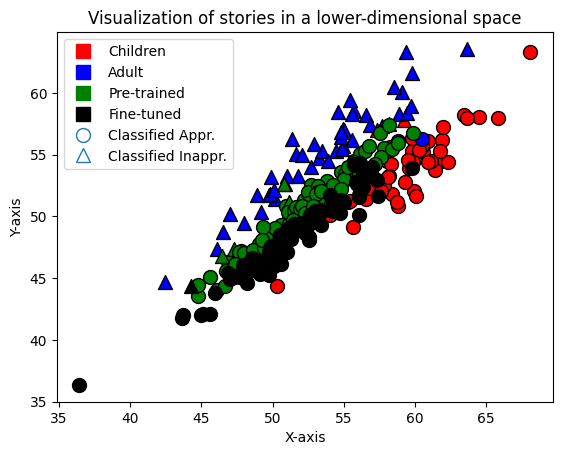

In [ ]:
#@title Visualize new stories

# find labels for the gpt2-generated stories
X_new = get_embeddings(new_stories, emb_tokenizer, emb_model)
X = np.concatenate([X, X_new], axis=0)

Y_new = X_new @ centers.transpose()
labels_new = (Y_new[:,0] < Y_new[:,1]).astype(int)
all_labels = np.concatenate([all_labels, labels_new], axis=0)

colors = colors + ['black']*len(new_stories)

markers = ['o' if label == 0 else '^' for label in all_labels]

x = X @ centers.transpose()

myPlot(x, colors, markers)